Patterns based on all time, compare each point with previous. Best:

In [55]:
#Import functions
import polars as pl
from functools import partial
from itertools import product, combinations
import multiprocessing
from numba import jit
import numpy as np
import pickle
import matplotlib.pyplot as plt
import datetime
import math
from dateutil.relativedelta import relativedelta

In [56]:
#Load dataframe from CSV
ticker = "NVDA"
current_df=pl.read_csv(f"../Data/SP500/minuteHist2021/tradingHours/{ticker}.csv", infer_schema_length=None)

In [57]:
#Get prices and timestamps from dataframe
open_prices=current_df['open'].to_numpy()
close_prices=current_df['close'].to_numpy()
timestamps=current_df['time'].to_numpy()

In [58]:
#Join data into one 2d array
data_array = np.dstack((open_prices, close_prices, timestamps))[0]
len(data_array)

259878

In [59]:
#Algo
#Numba for speed
@jit(nopython=True, nogil=True)
def algo(params_list, data_array):
    fee=params_list[0] #Percent change in price to look for
    fee_type=params_list[1] #The type of fee, 0 for percent, 1 for fixed
    timeout=int(params_list[2]) #The timeout when it takes too long
    gap=int(params_list[3]) #The gap between the two prices
    params=params_list[4:]
    open_prices=data_array[:,0]
    
    #params has an array of arrays with ticks before, change, version
    
    trade_percent=0
    total_return=1

    total=0

    start=60 #Start of data
    end=int(len(open_prices)-61) #End of data
    
    for j in range(start, end):
        #Check that its not within the first or last hour of trading
        if 0<data_array[j][2]-data_array[j-60][2]<4500000 and 0<data_array[j+60][2]-data_array[j][2]<4500000:

        #Check that its all within one day of trading
        #if 0<data_array[j][2]-data_array[j-(gap*len(params))][2]<(60000*gap*len(params)*1.25) and 0<data_array[j+timeout][2]-data_array[j][2]<(60000*timeout*1.25):

        #Check that its all within first or last hour of trading
        #if 4500000<data_array[j][2]-data_array[j-60][2] or 4500000<data_array[j+60][2]-data_array[j][2]:

            #Set start price and continue
            continue_params=True

            for k in range(len(params)):
                change = params[k]

                #Set price we are checking
                price_after=data_array[j-(gap*(k))][0]
                price_before=data_array[j-(gap*(k+1))][0]

                #If price now is above price we are checking, then continue, 1 means a price increase
                if price_after*change<price_before*change:
                    continue_params = False
                    break

            if continue_params:

                #Add to tally
                total+=1

                #Return on investment = new price / old price
                if fee_type==0:
                    return_value = (data_array[j+timeout][0]*(1-fee))/data_array[j][0]
                elif fee_type==1:
                    return_value = (data_array[j+timeout][0]-fee)/data_array[j][0]
                total_return*=return_value
                trade_percent+=return_value
        
    if total>0:
        trade_percent=trade_percent/total
        
    #Return the average trade percent, the total number of times, timeout, gap, and the parameters
    return_list = [trade_percent, total_return, total, timeout, gap] + [param for param in params]
    return return_list
    # print(trade_percent)
    # print(tradePerDay)

#algo with all the dataframes already passed through
partialAlgo = partial(algo, data_array=data_array)

In [60]:
#Test algo to compile it
algo(np.array([0.001, 0, 50.00, 1, 1, 1, 1]), data_array)

[0.9991750273589205, 5.080888403126358e-09, 22403.0, 50.0, 1.0, 1.0, 1.0, 1.0]

In [8]:
#Params
#rough commission fee
fee=[0.005]

fee_type=[1] #0 for percent, 1 for fixed

#timeout
timeout_list=[1,2,3,5,10,20,30,50]

#Gap between price points
gap_list=[1,2,3,5]

#Up, down
up_down=[1, -1]

full_combinations=list(product(fee, fee_type, timeout_list, gap_list, up_down, up_down, up_down, up_down, up_down, up_down, up_down, up_down, up_down, up_down))

len(full_combinations)

32768

In [9]:
#Run the algo over the full combinations list with multiprocessing

#List of results to store in right order
all_results=[]

#Start multiprocessing
with multiprocessing.Pool(15) as pool:
    for result in pool.map(
        partialAlgo,
        full_combinations
    ):
        #Check if the total tally is high enough to be reasonable
        all_results.append(result)

In [13]:
file_path = f"../Results/sp500/V4/{ticker}-minute2021-midday-33kParams-incFees.pkl" #Save file to pickle

# Save the all_results variable using pickle
with open(file_path, "wb") as file:
    pickle.dump(all_results, file)

In [14]:
def getSortedResults(current_results, minimum, maximum, n): #Function to sort the results
    results=[]

    for result in current_results:
        if maximum>=result[2]>=minimum:
            results.append(result)

    sorted_results = sorted(results.copy(), reverse=True)
    sorted_total_results = sorted(results.copy(), reverse=True, key=lambda x: x[1])
    results_df=pl.DataFrame(sorted_results[0:n], schema=["Return", "Total return", "Frequency", "Timeout", "Gap"] + [f"Param {i}" for i in range(1, len(sorted_results[0])-4)])
    results_dfTotal=pl.DataFrame(sorted_total_results[0:n], schema=["Return", "Total return", "Frequency", "Timeout", "Gap"] + [f"Param {i}" for i in range(1, len(sorted_results[0])-4)])
    return results_df, results_dfTotal

In [19]:
#Get all day
file_path1 = f"../Results/sp500/V4/{ticker}-minute2021-allday-33kParams-incFees.pkl"

with open(file_path1, 'rb') as file:
    all_results1 = pickle.load(file)

sorted_results1, sorted_total_results1=getSortedResults(all_results1, 100, 100000, 500)
sorted_total_results1[:5]

Return,Total return,Frequency,Timeout,Gap,Param 1,Param 2,Param 3,Param 4,Param 5,Param 6,Param 7,Param 8,Param 9,Param 10
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.001253,1.260324,186.0,50.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,1.0
1.001217,1.257932,190.0,50.0,2.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0
1.000895,1.236272,239.0,30.0,2.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0
1.000941,1.233656,225.0,50.0,5.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0
1.000699,1.218976,287.0,50.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,-1.0


In [34]:
#Get mid day
file_path2 = f"../Results/sp500/V4/{ticker}-minute2021-midday-33kParams-incFees.pkl"
# Load data from pickle file
with open(file_path2, 'rb') as file:
    all_results2 = pickle.load(file)

sorted_results2, sorted_total_results2=getSortedResults(all_results2, 100, 100000, 500)
sorted_total_results2[:5]

Return,Total return,Frequency,Timeout,Gap,Param 1,Param 2,Param 3,Param 4,Param 5,Param 6,Param 7,Param 8,Param 9,Param 10
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.002043,1.516478,207.0,50.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0
1.002139,1.514398,196.0,50.0,5.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0
1.00206,1.513975,206.0,50.0,5.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0
1.002343,1.491477,173.0,50.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0
1.001965,1.483306,204.0,50.0,5.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0


In [21]:
#Get out day
file_path3 = f"../Results/sp500/V4/{ticker}-minute2021-outday-33kParams-incFees.pkl"
# Load data from pickle file
with open(file_path3, 'rb') as file:
    all_results3 = pickle.load(file)

sorted_results3, sorted_total_results3=getSortedResults(all_results3, 100, 100000, 500)
sorted_total_results3[:5]

Return,Total return,Frequency,Timeout,Gap,Param 1,Param 2,Param 3,Param 4,Param 5,Param 6,Param 7,Param 8,Param 9,Param 10
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.00299,1.398995,114.0,50.0,5.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0
1.003175,1.364268,100.0,50.0,3.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0
1.002567,1.353184,120.0,50.0,2.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0
1.002911,1.340924,103.0,50.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0
1.002713,1.303919,100.0,50.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0


In [35]:
#Split into time segments

start_unix = 1615780800000
end_unix = 1699070340000
months = (datetime.datetime.fromtimestamp(end_unix / 1000).year - datetime.datetime.fromtimestamp(start_unix / 1000).year) * 12 + (datetime.datetime.fromtimestamp(end_unix / 1000).month - datetime.datetime.fromtimestamp(start_unix / 1000).month) + 1


#Split into 2 week segments
week_dfs2 = []
for k in range(start_unix, end_unix, 1209600000):
    current=k
    temp_df=current_df.filter((pl.col("time")) >= current)
    temp_df=temp_df.filter((pl.col("time")) < current+1209600000)
    week_dfs2.append(temp_df)
len(week_dfs2)

#Convert 2 week dataframes to numpy arrays
week2_data_array=[]
for k in range(len(week_dfs2)):
    week2_data_array.append(np.dstack((week_dfs2[k]['open'].to_numpy(), week_dfs2[k]['close'].to_numpy(), week_dfs2[k]['time'].to_numpy()))[0])
len(week2_data_array)


#Split into 1 week segments
week_dfs1 = []
for k in range(start_unix, end_unix, 604800000):
    current=k
    temp_df=current_df.filter((pl.col("time")) >= current)
    temp_df=temp_df.filter((pl.col("time")) < current+604800000)
    week_dfs1.append(temp_df)
len(week_dfs1)

#Convert 1 week dataframes to numpy arrays
week_data_array=[]
for k in range(len(week_dfs1)):
    week_data_array.append(np.dstack((week_dfs1[k]['open'].to_numpy(), week_dfs1[k]['close'].to_numpy(), week_dfs1[k]['time'].to_numpy()))[0])
len(week_data_array)


#Split into 1 day segments
day_dfs = []
for k in range(start_unix, end_unix, 86400000):
    current=k
    temp_df=current_df.filter((pl.col("time")) >= current)
    temp_df=temp_df.filter((pl.col("time")) < current+86400000)
    if len(temp_df)>0:
        day_dfs.append(temp_df)
len(day_dfs)

#Convert day dataframes to numpy arrays
day_data_array=[]
for k in range(len(day_dfs)):
    day_data_array.append(np.dstack((day_dfs[k]['open'].to_numpy(), day_dfs[k]['close'].to_numpy(), day_dfs[k]['time'].to_numpy()))[0])
len(day_data_array)


#Split into 1 month segments
month_dfs = []
current_month = datetime.datetime.fromtimestamp(day_dfs[0][0]['time'][0] / 1000).month
temp_df = day_dfs[0]
for k in range(len(day_dfs)):
    if current_month == datetime.datetime.fromtimestamp(day_dfs[k][0]['time'][0] / 1000).month:
        temp_df.extend(day_dfs[k])
    else:
        month_dfs.append(temp_df)
        current_month = datetime.datetime.fromtimestamp(day_dfs[k][0]['time'][0] / 1000).month
        temp_df = day_dfs[k]

#Convert month dataframes to numpy arrays
month_data_array=[]
for k in range(len(month_dfs)):
    month_data_array.append(np.dstack((month_dfs[k]['open'].to_numpy(), month_dfs[k]['close'].to_numpy(), month_dfs[k]['time'].to_numpy()))[0])
len(month_data_array)

#Split into 1 day segments
day_dfs = []
for k in range(start_unix, end_unix, 86400000):
    current=k
    temp_df=current_df.filter((pl.col("time")) >= current)
    temp_df=temp_df.filter((pl.col("time")) < current+86400000)
    day_dfs.append(temp_df)
len(day_dfs)

#Convert day dataframes to numpy arrays
day_data_array=[]
for k in range(len(day_dfs)):
    day_data_array.append(np.dstack((day_dfs[k]['open'].to_numpy(), day_dfs[k]['close'].to_numpy(), day_dfs[k]['time'].to_numpy()))[0])
len(day_data_array)

964

Correlation Coefficient: 0.9738032118717065


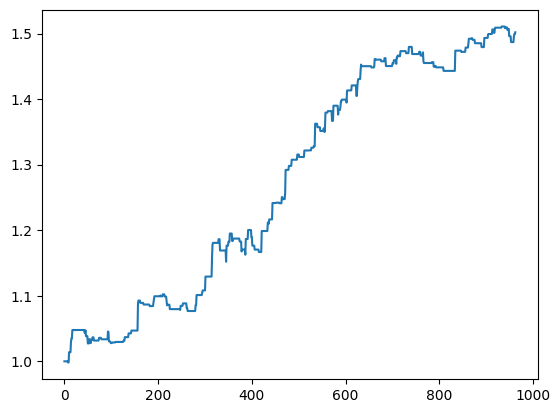

In [36]:
#Graph of PnL over time and print correlation
return_over_time=[]
for k in range(1, len(day_dfs)):
    current_data_array = np.concatenate(day_data_array[:k])
    return_over_time.append(algo(np.array([0.005, 1]+list(sorted_total_results2[0,3:].rows()[0])), current_data_array)[1])
plt.plot(return_over_time)
#plt.yscale("log")

y = np.array(return_over_time)
x = np.array(range(len(return_over_time)))
correlation_coefficient = np.corrcoef(x, y)[0,1]
print("Correlation Coefficient:", correlation_coefficient)

In [37]:
#Functions for graph of PnL for each period with anomolies

def sharpeRatio(returns, increment):
    match increment:
        case "day":
            periods = 252
        case "week":
            periods = 52
        case "month":
            periods = 12
    risk_free_rate = (1.06**(1/periods)) - 1
    sharpe_ratio = (np.mean(returns) - risk_free_rate) / np.std(returns) * math.sqrt(periods)
    return sharpe_ratio

def sortinoRatio(returns, increment):
    match increment:
        case "day":
            periods = 252
        case "week":
            periods = 52
        case "month":
            periods = 12
    risk_free_rate = (1.06**(1/periods)) - 1
    np_returns = np.array(returns)
    downside_returns = np.where(np_returns < risk_free_rate, np_returns - risk_free_rate, 0)
    downside_deviation = np.std(downside_returns)
    sortino_ratio = (np.mean(returns) - risk_free_rate) / downside_deviation * math.sqrt(periods)
    return sortino_ratio

def plot(increment, start = datetime.datetime(2021, 3, 15) , end = datetime.datetime(2023, 11, 3)):

    beginning=datetime.datetime(2021, 3, 15)
    match increment:
        case "day":
            start_index = (start - beginning).days
            end_index = (end - beginning).days
            used_data_array = day_data_array
        case "week":
            start_index = (start - beginning).days//7
            end_index = (end - beginning).days//7
            used_data_array = week_data_array
        case "month":
            start_index = relativedelta(start, beginning).months + relativedelta(start, beginning).years*12
            end_index = relativedelta(end, beginning).months + relativedelta(end, beginning).years*12
            used_data_array = month_data_array

    return_per_day=[]
    dates=[]
    for k in range(start_index, end_index+1):
        if used_data_array[k].shape[0]>0:
            result = algo(np.array([0.005, 1]+list(sorted_total_results1[0,3:].rows()[0])), used_data_array[k])[1]-1
            return_per_day.append(result)
            dates.append(datetime.datetime.fromtimestamp(used_data_array[k][0][2] / 1000))
    plt.scatter(dates, return_per_day, s=10)
    plt.grid()

    mean_return = np.mean(return_per_day)
    std_deviation = np.std(return_per_day)
    risk_free_rate = (1.06**(1/252)) - 1
    print("Annualized sharpe Ratio:", sharpeRatio(return_per_day, increment))
    print("Annualized sortino Ratio:", sortinoRatio(return_per_day, increment))

def plotAnomalies(increment, resultThreshold=-math.inf, print_true = False, start = datetime.datetime(2021, 3, 15) , end = datetime.datetime(2023, 11, 3)):
    beginning=datetime.datetime(2021, 3, 15)
    match increment:
        case "day":
            start_index = (start - beginning).days
            end_index = (end - beginning).days
            used_data_array = day_data_array
        case "week":
            start_index = (start - beginning).days//7
            end_index = (end - beginning).days//7
            used_data_array = week_data_array
        case "month":
            start_index = relativedelta(start, beginning).months + relativedelta(start, beginning).years*12
            end_index = relativedelta(end, beginning).months + relativedelta(end, beginning).years*12
            used_data_array = month_data_array

    return_per_day=[]
    dates=[]
    over_threshold = []
    for k in range(start_index, end_index+1):
        if used_data_array[k].shape[0]>0:
            result = algo(np.array([0.005, 1]+list(sorted_total_results1[0,3:].rows()[0])), used_data_array[k])[1]-1
            if result > resultThreshold or result < -resultThreshold:
                over_threshold.append((datetime.datetime.fromtimestamp(used_data_array[k][0][2] / 1000), result))
                return_per_day.append(result)
                dates.append(datetime.datetime.fromtimestamp(used_data_array[k][0][2] / 1000))
    plt.scatter(dates, return_per_day, s=10)
    if print_true:
        for k in range(len(over_threshold)):
            print(over_threshold[k][0].date(), over_threshold[k][1])

Annualized sharpe Ratio: -0.2439806164196235
Annualized sortino Ratio: -0.3615631076067879


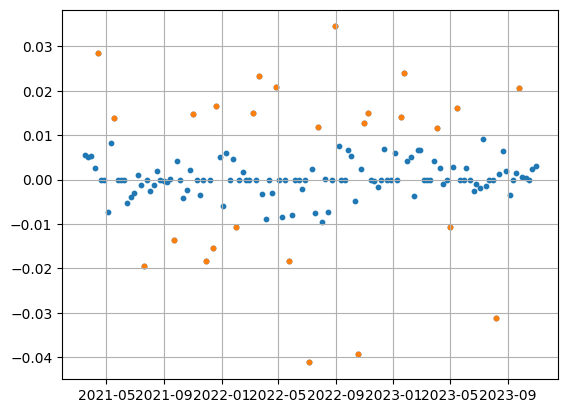

In [38]:
#Start date is 2021-03-15, end date is 2023-11-03
start_date = datetime.datetime(2022, 1, 1)
end_date = datetime.datetime(2023, 11, 3)
increment = "week"
anomaly = 0.01
plot(increment)
plotAnomalies(increment, anomaly, print_true=False)

In [39]:
#MultiAlgo
#Numba for speed
@jit(nopython=True, nogil=True)
def multiAlgo(concurrent, params_list, data_array):
    fee=params_list[0] #Percent change in price to look for
    fee_type=params_list[1] #The type of fee, 0 for percent, 1 for fixed
    all_params=params_list[2:]
    params = []
    for k in range(concurrent):
        params.append(all_params[k*len(all_params)//concurrent:(k+1)*len(all_params)//concurrent])
    open_prices=data_array[:,0]
    
    #params has an array of arrays with ticks before, change, version
    
    trade_percent=0
    total_return=1

    total=0

    start=100 #Start of data
    j=start
    end=int(len(open_prices)-61) #End of data
    
    while j < end:
        #Check that its not within the first or last hour of trading
        if 0<data_array[int(j)][2]-data_array[int(j-60)][2]<4500000 and 0<data_array[int(j+60)][2]-data_array[int(j)][2]<4500000:

        #Check that its all within one day of trading
        #if 0<data_array[j][2]-data_array[j-(gap*len(params))][2]<(60000*gap*len(params)*1.25) and 0<data_array[j+timeout][2]-data_array[j][2]<(60000*timeout*1.25):

        #Check that its all within first or last hour of trading
        #if 4500000<data_array[j][2]-data_array[j-60][2] or 4500000<data_array[j+60][2]-data_array[j][2]:

            h=0
            while h < concurrent:
                timeout = params[h][0]
                gap = params[h][1]
                currentParams = params[h][2:]

                continue_params=True

                for k in range(len(currentParams)):
                    change = currentParams[k]

                    #Set price we are checking
                    price_after=data_array[int(j-(gap*(k)))][0]
                    price_before=data_array[int(j-(gap*(k+1)))][0]

                    #If price now is above price we are checking, then continue, 1 means a price increase
                    if price_after*change<price_before*change:
                        continue_params = False
                        break

                if continue_params:
                    #Add to tally
                    h=concurrent
                    total+=1

                    #Return on investment = new price / old price
                    if fee_type==0:
                        return_value = (data_array[int(j+timeout)][0]*(1-fee))/data_array[int(j)][0]
                    elif fee_type==1:
                        return_value = (data_array[int(j+timeout)][0]-fee)/data_array[int(j)][0]
                    total_return*=return_value
                    trade_percent+=return_value
                    j+=timeout
                h+=1
        j+=1
        
    if total>0:
        trade_percent=trade_percent/total
        
    #Return the average trade percent, the total number of times, timeout, gap, and the parameters
    return_list = [trade_percent, total_return, total]
    return return_list

In [41]:
#Choose how many concurrent algos to run
params_list = range(15)
params = [0.005, 1.0]
for k in params_list:
    params += list(sorted_total_results2[k,3:].rows()[0])
concurrent = len(params)//len(sorted_total_results2[0,3:].rows()[0])

multiAlgo(concurrent, params, data_array)

[1.0014985272064925, 8.40457076654743, 1447.0]

Correlation Coefficient: 0.9706128697383426


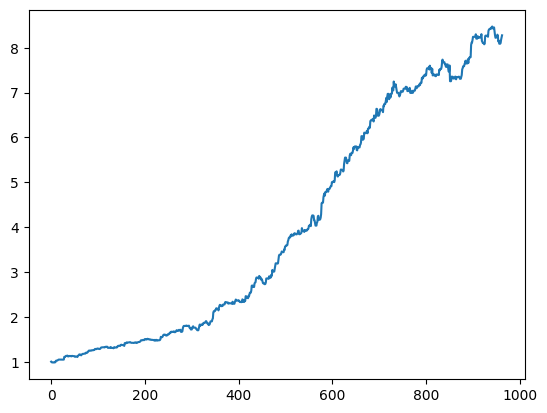

In [44]:
#Graph of PnL over time and print correlation
return_over_time=[]
points = range(1, len(day_data_array))
for k in points:
    start_time = datetime.time
    current_data_array = np.concatenate(day_data_array[:k])
    return_over_time.append(multiAlgo(concurrent, params, current_data_array)[1])
plt.plot(return_over_time)
#plt.yscale("log")

y = np.array(return_over_time)
x = np.array(points)
correlation_coefficient = np.corrcoef(x, y)[0,1]
print("Correlation Coefficient:", correlation_coefficient)

AttributeError: 'range' object has no attribute 'append'

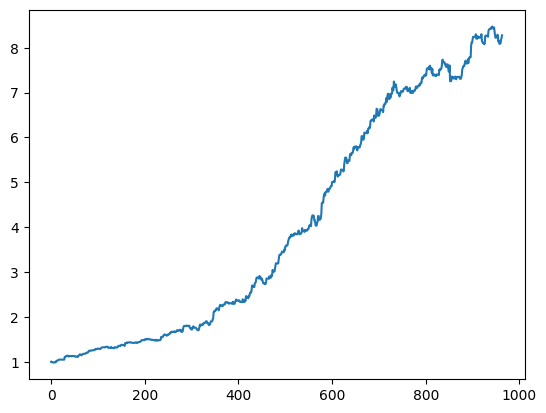

In [54]:
#Graph of PnL over time and print correlation
return_over_time=[1]
points = range(1, len(day_data_array))
for k in points:
    start_time = datetime.time
    current_data_array = np.concatenate(day_data_array[:k])
    return_over_time.append(multiAlgo(concurrent, params, current_data_array)[1])
plt.plot(return_over_time)
#plt.yscale("log")

y = np.array(return_over_time)
points.append(len(day_data_array))
x = np.array(points)
correlation_coefficient = np.corrcoef(x, y)[0,1]
print("Correlation Coefficient:", correlation_coefficient)

#Graph of PnL over time and print correlation 2
return_over_time=[1]
points = list(range(1,len(day_data_array)))
for k in points:
    start_time = datetime.time
    return_over_time.append(return_over_time[-1]*multiAlgo(concurrent, params, day_data_array[k])[1])
plt.plot(return_over_time)
#plt.yscale("log")

y = np.array(return_over_time)
points.append(len(day_data_array))
x = np.array(points)
correlation_coefficient = np.corrcoef(x, y)[0,1]
print("Correlation Coefficient:", correlation_coefficient)

In [ ]:
#Graph of PnL over time and print correlation
return_over_time=[1]
points = list(range(1,len(day_data_array)))
for k in points:
    start_time = datetime.time
    return_over_time.append(return_over_time[-1]*multiAlgo(concurrent, params, day_data_array[k])[1])
plt.plot(return_over_time)
#plt.yscale("log")

y = np.array(return_over_time)
points.append(len(day_data_array))
x = np.array(points)
correlation_coefficient = np.corrcoef(x, y)[0,1]
print("Correlation Coefficient:", correlation_coefficient)

In [42]:
#Functions for graph of PnL for each period with anomolies

def multiPlot(increment, start = datetime.datetime(2021, 3, 15) , end = datetime.datetime(2023, 11, 3)):

    beginning=datetime.datetime(2021, 3, 15)
    match increment:
        case "day":
            start_index = (start - beginning).days
            end_index = (end - beginning).days
            used_data_array = day_data_array
        case "week":
            start_index = (start - beginning).days//7
            end_index = (end - beginning).days//7
            used_data_array = week_data_array
        case "month":
            start_index = relativedelta(start, beginning).months + relativedelta(start, beginning).years*12
            end_index = relativedelta(end, beginning).months + relativedelta(end, beginning).years*12
            used_data_array = month_data_array

    return_per_day=[]
    dates=[]
    for k in range(start_index, end_index+1):
        if used_data_array[k].shape[0]>0:
            result = multiAlgo(concurrent, params, used_data_array[k])[1]-1
            return_per_day.append(result)
            dates.append(datetime.datetime.fromtimestamp(used_data_array[k][0][2] / 1000))
    plt.scatter(dates, return_per_day, s=10)
    plt.grid()

    print("Annualized sharpe Ratio:", sharpeRatio(return_per_day, increment))
    print("Annualized sortino Ratio:", sortinoRatio(return_per_day, increment))
    


def multiPlotAnomalies(increment, resultThreshold=-math.inf, print_true = False, start = datetime.datetime(2021, 3, 15) , end = datetime.datetime(2023, 11, 3)):
    beginning=datetime.datetime(2021, 3, 15)
    match increment:
        case "day":
            start_index = (start - beginning).days
            end_index = (end - beginning).days
            used_data_array = day_data_array
        case "week":
            start_index = (start - beginning).days//7
            end_index = (end - beginning).days//7
            used_data_array = week_data_array
        case "month":
            start_index = relativedelta(start, beginning).months + relativedelta(start, beginning).years*12
            end_index = relativedelta(end, beginning).months + relativedelta(end, beginning).years*12
            used_data_array = month_data_array

    return_per_day=[]
    dates=[]
    over_threshold = []
    for k in range(start_index, end_index+1):
        if used_data_array[k].shape[0]>0:
            result = multiAlgo(concurrent, params, used_data_array[k])[1]-1
            if result > resultThreshold or result < -resultThreshold:
                over_threshold.append((datetime.datetime.fromtimestamp(used_data_array[k][0][2] / 1000), result))
                return_per_day.append(result)
                dates.append(datetime.datetime.fromtimestamp(used_data_array[k][0][2] / 1000))
    plt.scatter(dates, return_per_day, s=10)
    if print_true:
        for k in range(len(over_threshold)):
            print(over_threshold[k][0].date(), over_threshold[k][1])

Annualized sharpe Ratio: 4.23732557965558
Annualized sortino Ratio: 9.780150926043422


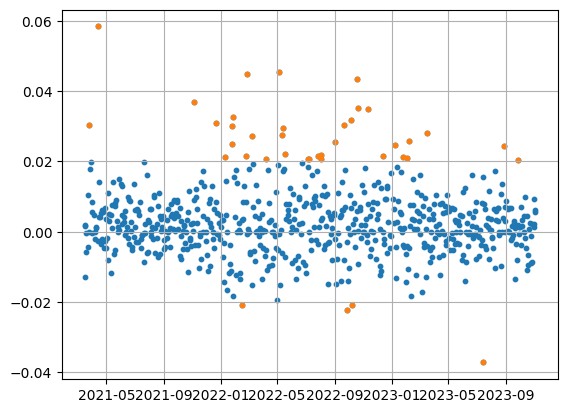

In [43]:
#Start date is 2021-03-15, end date is 2023-11-03
start_date = datetime.datetime(2021, 3, 15)
end_date = datetime.datetime(2023, 11, 3)
increment = "day"
anomaly = 0.02
multiPlot(increment)
multiPlotAnomalies(increment, anomaly, print_true=False)